# Fudan PRML Fall 2024 Exercise 4: Unsupervised Learning

![news](./news.png)

- Name: 杨淳瑜
- Student ID: 22307140114

In this assignment, you will build a **text classification** system which is a fundamental task in the field of Natural Language Processing (NLP). More precisely, you are given a news classification task, assigning given news texts to the categories to which they belong. Unlike traditional classification tasks, **we did not provide you with any labels for this assignment, and you need to find a way to construct labels for these articles**. 

For this assignment you can use commonly used deep learning frameworks like PyTorch. **You can use pretrained word vectors like Glove, but not pretrained large models like BERT.**

# 1. Setup

In [8]:
# setup code
%load_ext autoreload
%autoreload 2
import os
import pickle 
import numpy as np
from sklearn.cluster import KMeans

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
dataset_path = 'kmeans_news.pkl'

all_data = None
with open(dataset_path,'rb') as fin:
    all_data = pickle.load(fin)
    all_data_np = np.array(all_data)

print ('\n'.join(all_data[0:5]))
print ('Total number of news: {}'.format(len(all_data)))

经济学家吴敬琏为什么反对“不惜代价发展芯片产业”？
颜值很高的她，一双美腿甚至可以让人忽略她的颜值
转自常德诗人”再访桃花源“（再续心灵故乡的故事）
虎牙拼杀四年抢得游戏直播第一股 但真正的挑战才刚开始
如何评价许鞍华导演？她的电影为什么总能给人以触动？
Total number of news: 83360


# 2. Exploratory Data Analysis

Not all data within the dataset is suitable for clustering. You might need to filter and process some of them in advance.

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert list of news articles into a DataFrame for easier manipulation
news_df = pd.DataFrame(all_data, columns=['text'])

# Display basic statistics about the 
print(news_df.head())
print(news_df.describe())

                         text
0   经济学家吴敬琏为什么反对“不惜代价发展芯片产业”？
1     颜值很高的她，一双美腿甚至可以让人忽略她的颜值
2    转自常德诗人”再访桃花源“（再续心灵故乡的故事）
3  虎牙拼杀四年抢得游戏直播第一股 但真正的挑战才刚开始
4   如何评价许鞍华导演？她的电影为什么总能给人以触动？
                     text
count               83360
unique              76120
top     上联：泰山黄山赵本山，如何对下联？
freq                  101


In [11]:
# Remove duplicate rows based on the 'text' column
news_df.drop_duplicates(subset='text', inplace=True)

# Reset the index after removing duplicates
news_df.reset_index(drop=True, inplace=True)

# Display basic statistics after removing duplicates
print(news_df.describe())
print(news_df.head())

                         text
count                   76120
unique                  76120
top     为什么世界第一的巨星迈克尔杰克逊下场凄惨？
freq                        1
                         text
0   经济学家吴敬琏为什么反对“不惜代价发展芯片产业”？
1     颜值很高的她，一双美腿甚至可以让人忽略她的颜值
2    转自常德诗人”再访桃花源“（再续心灵故乡的故事）
3  虎牙拼杀四年抢得游戏直播第一股 但真正的挑战才刚开始
4   如何评价许鞍华导演？她的电影为什么总能给人以触动？


In [12]:
# Check for any missing values in the dataset
print("Missing values in the dataset:")
print(news_df.isnull().sum())

Missing values in the dataset:
text    0
dtype: int64


News article length distribution:
count    76120.000000
mean        22.288334
std          7.355647
min          2.000000
25%         17.000000
50%         23.000000
75%         28.000000
max        145.000000
Name: length, dtype: float64


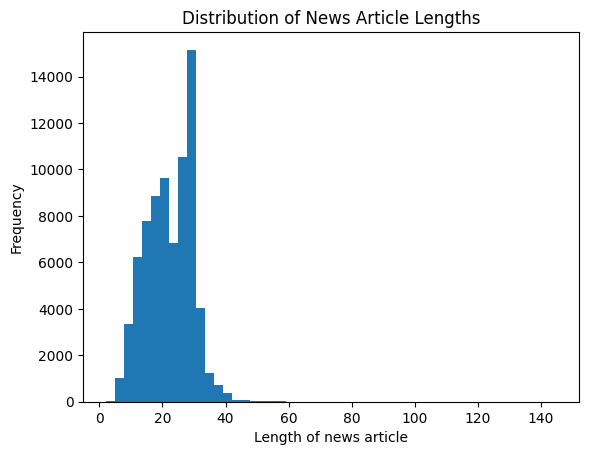

In [13]:
# Check the length of each news article
news_df['length'] = news_df['text'].apply(len)

# Display the distribution of news article lengths
print("News article length distribution:")
print(news_df['length'].describe())

# Visualize the distribution of article lengths
import matplotlib.pyplot as plt
plt.hist(news_df['length'], bins=50)
plt.xlabel('Length of news article')
plt.ylabel('Frequency')
plt.title('Distribution of News Article Lengths')
plt.show()

# 3. Get embeddings for the news

We need to convert the news titles into some kind of numerical representation (embedding) before we can do clustering on them. Below are two ways to get embeddings for a paragraph of text:

1. **Pretrained word embeddings**: You can use pretrained word embeddings like Glove to get embeddings for each word in the news, and then average them (or try some more advanced techniques) to get the news embedding.

2. **General text embedding models**: You can use general text embedding models to get embedding for a sentence directly.

You can choose either of them to convert the news titles into embeddings.

In [15]:
# import numpy as np
# import spacy

# spacy.require_gpu()

# # Load the medium English model with Glove vectors
# nlp = spacy.load('zh_core_web_sm')

# def get_embedding(text):
#     # Returns the average embedding of the text
#     doc = nlp(text)
#     return np.mean([word.vector.get() for word in doc if word.has_vector], axis=0)

# # Apply the function to each news article
# news_df['embedding'] = news_df['text'].apply(get_embedding)

# # Convert the list of embeddings into a numpy array for clustering
# embeddings = np.vstack(news_df['embedding'].values)

# # Now, embeddings can be used for clustering
# print("Shape of embeddings array:", embeddings.shape)


In [16]:
import torch
from transformers import AutoTokenizer, AutoModel
import pandas as pd
from tqdm import tqdm

# Load the DataFrame (assuming 'news_df' is already defined)
# news_df = pd.read_csv('your_file.csv')  # Uncomment if loading from a CSV

# Load a pre-trained model and tokenizer for Chinese text
model_name = 'hfl/chinese-roberta-wwm-ext'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to('cuda')

# Function to convert a list of texts to embeddings
def get_embeddings(texts, batch_size=32):
    embeddings_list = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        
        # Tokenize and move inputs to GPU
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512).to('cuda')
        
        # Get embeddings
        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1)  # Average pooling over the sequence length
            embeddings_list.append(embeddings.cpu())
    
    return torch.cat(embeddings_list, dim=0)

# Convert the 'text' column to embeddings
texts = news_df['text'].tolist()
embeddings = get_embeddings(texts, batch_size=64)

# Save embeddings as a numpy array if needed
import numpy as np
np.save('embeddings.npy', embeddings.numpy())

print(f"Embeddings shape: {embeddings.shape}")


tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/412M [00:00<?, ?B/s]

100%|██████████| 1190/1190 [02:16<00:00,  8.74it/s]


Embeddings shape: torch.Size([76120, 768])


# 4. Clustering

Do K-means clustering

In [24]:
from sklearn.cluster import KMeans

embeddings = np.load('embeddings.npy')

# Number of clusters
clusters = 30

random_sample = True

# Perform K-means clustering
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(embeddings)

# Display the number of articles in each cluster and a few sample articles from each cluster
for i in range(clusters):
    print(f'Cluster {i} has {np.sum(kmeans.labels_ == i)} articles')
    
    # Choose whether to sample randomly or take the first few articles
    if random_sample:
        # Randomly select 5 articles from the cluster
        indices = np.random.choice(np.where(kmeans.labels_ == i)[0], 20, replace=False).tolist()
    else:
        # Select the first 5 articles from the cluster
        indices = np.where(kmeans.labels_ == i)[0][:20].tolist()
    
    # Print the selected articles
    print(news_df.loc[indices, 'text'])
    print('')  # Print a newline for better readability between clusters


Cluster 0 has 2024 articles
7692               电动汽车能不能直接装台发电机，取消电池？
32747              部队里学驾照和我们一般人学的有什么区别？
6007         数字资产是资产的数字化还是数字的资产化呢，你怎么看？
62676                土地确权以后国家收回会给多少补偿款？
55872               住着100万的房子，我算不算百万富翁？
1296               重庆房价那么低，为何也有到处流浪的人呢？
55427      假如微信开始收费(每月6、49、99元），你还会不会用？
75053          江苏文科二模一本线上16分，财经类能考什么大学？
6417          5W的资金交易恒指，这样弄行不？（5月3日的记录）
4772               作为一个云南小伙子，去北上广发展怎么样？
74229               韶关市中小微企业的生存和发展现状如何？
62140        一生病就吃抗生素，会有什么后果？这种做法医生都不推崇
12847    广州哪里贴改色膜专业？贴改色膜需要注意什么？奔驰改拉丝黑分享
58284                初中学历怎样才能找到月薪上万的工作？
53952              土鸡蛋真的比商品蛋营养价值高吗？不见得吧
75317     电脑显卡起到什么作用？易学易懂方式科普显卡核心参数基础知识
37015           使用钉子划隐形车衣，钉子真的划不破隐形车衣吗？
45359           除了种养，还有些什么好项目可以在农村创业致富？
30448           该如何确认你的融资需求呢，我想从三个维度来讲？
59172            爱车总是蹭地，怎样增加离地间距，提高通过性？
Name: text, dtype: object

Cluster 1 has 1278 articles
6116                      雷克萨斯ES究竟有多大的实力
48947                   速腾让利促销中 价格直降3.4万
3909              18万左右落地，有哪些适合90后的